### Regression model

In [27]:
import pandas as pd
import geopandas as gpd
import pickle
from pysal.lib import weights # import weight lib
from sklearn.model_selection import train_test_split
from sklearn import cluster
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [107]:
import statsmodels.graphics.api as smg
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tools.eval_measures import rmse
from math import *


In [4]:
with open('RegressionDF.pickle', 'rb') as handle:
    RegDf = pickle.load(handle)

In [18]:
all_cities = pd.concat([RegDf['rotterdam'], RegDf['munich'], RegDf['zurich'], RegDf['frankfurt'], RegDf['hamburg']])

In [19]:
all_cities = all_cities[all_cities['flow'].notna()]

In [21]:
all_cities = all_cities.fillna(0)

In [22]:
all_cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2329 entries, 0 to 418
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   detid            2329 non-null   object  
 1   flow             2329 non-null   float64 
 2   City             2329 non-null   object  
 3   geometry         2329 non-null   geometry
 4   NeighboursTotal  2329 non-null   float64 
 5   station          2329 non-null   int64   
 6   cycleway         2329 non-null   int64   
 7   footway          2329 non-null   int64   
 8   pedestrian       2329 non-null   int64   
 9   footwayplatform  2329 non-null   float64 
dtypes: float64(3), geometry(1), int64(4), object(2)
memory usage: 200.1+ KB


In [23]:
def regression(y_array, x_array, df):
    
    # the df is split into a training and testing set
    # the test size is 0.2%, since the df is not very large
    traindf, testdf = train_test_split(df, test_size=0.2, random_state=42)
    print(f'Shape of the training set is {traindf.shape} and of the testing set is {testdf.shape}.')

    # creates arrays for the predicted variable and the prediction variables
    y_train = traindf[y_array]
    x_train = traindf[x_array]

    y_test = testdf[y_array]
    x_test = testdf[x_array]
    
    x_train = pd.get_dummies(x_train, columns=['City'])
    x_test = pd.get_dummies(x_test, columns=['City'])
    
    # create the X matrix by appending a column of ones to x_train and x_test
    train_data_augmented = sm.add_constant(x_train)
    test_data_augmented = sm.add_constant(x_test)

    # build the OLS model (ordinary least squares) from the training data
    OLS_model = sm.OLS(y_train, train_data_augmented)

    # do the fit and save regression info (parameters, etc) in OLS_results
    OLS_results = OLS_model.fit()
    
    # get the prediction results for the test set
    predy_test = OLS_results.predict(test_data_augmented)
    
    return [OLS_results, y_train, x_train, y_test, x_test, predy_test]



Shape of the training set is (1863, 10) and of the testing set is (466, 10).


### First iteration model

In [ ]:
regression_model1, y_train1, x_train1, y_test1, x_test1, predy_test1\
= regression(['flow'], ['station', 'cycleway', 'footway', 'pedestrian', 'City', 'footwayplatform'], all_cities )

In [24]:
print(regression_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     16.77
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           7.88e-27
Time:                        21:24:03   Log-Likelihood:                -11890.
No. Observations:                1863   AIC:                         2.380e+04
Df Residuals:                    1853   BIC:                         2.385e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             175.9454      6.019     

In [25]:
def linearity_check(x_train, y_train, residuals, predy_train):
    # create plot
    fig, ax = plt.subplots(1,3, figsize=(20,5))

    # create regresion between y and predicted y
    sns.regplot(predy_train, y_train, ax=ax[0])
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    # create regression plot with residuals and predicted y
    sns.regplot(predy_train, residuals, ax=ax[1])
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residuals')

    # create kde plot of residuals
    sns.distplot(residuals, ax=ax[2])
    ax[2].set_xlabel('Residuals')
    ax[2].set_ylabel('Density')

    fig.suptitle('Linearity test', fontsize=25)

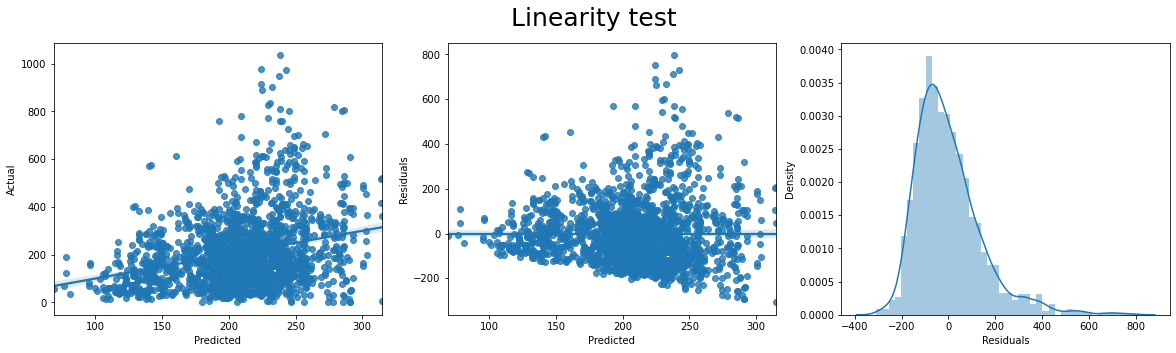

In [28]:
# residual analysis to determine whether assumption of linearity was correct
residuals1 = regression_model1.resid
predy_train1 = regression_model1.fittedvalues
#y_train1 = y_train1.reshape(y_train1.shape[0], )

linearity_check(x_train1, y_train1, residuals1, predy_train1)

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


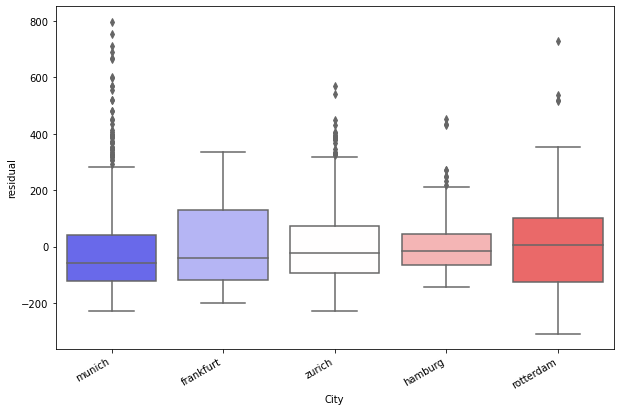

In [41]:
conditions = [
    x_train1['City_hamburg'] == 1, 
    x_train1['City_munich'] == 1, 
    x_train1['City_rotterdam'] == 1,
    x_train1['City_zurich']  == 1,
    x_train1['City_frankfurt'] == 1
]

outputs = [
    'hamburg', 'munich', 'rotterdam', 'zurich', 'frankfurt'
]



x_train_cities = x_train1[['station', 'cycleway', 'footway', 'pedestrian']]
x_train_cities['City'] = np.select(conditions, outputs, 'Other')
x_train_cities['residual'] = residuals1.values

medians = x_train_cities.groupby("City").residual.median().to_frame('city_residual')

f = plt.figure(figsize=(10,7))
ax = plt.gca()
sns.boxplot('City', 'residual', ax = ax,
                data=x_train_cities.merge(medians, how='left',
                              left_on='City',
                              right_index=True)
                   .sort_values('city_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

In [111]:
def get_teststats(y_test, predy_test):
    r2_score_test = r2_score(y_test, predy_test)
    MAE = mean_absolute_error(y_test, predy_test)
    mse = mean_squared_error(y_test, predy_test)
    rmse = sqrt(mse)
    return r2_score_test, MAE, rmse

In [112]:
R2score_model1, MAE_model1, rmse_model1 = get_teststats(y_test1, predy_test1)
print(f'R2-score 1: {R2score_model1}')
print(f'MAE 1:{MAE_model1}')
print(f'rmse 1: {rmse_model1}')

R2-score 1: 0.05753702376379277
MAE 1:107.78626793529291
rmse 1: 136.06502781180066


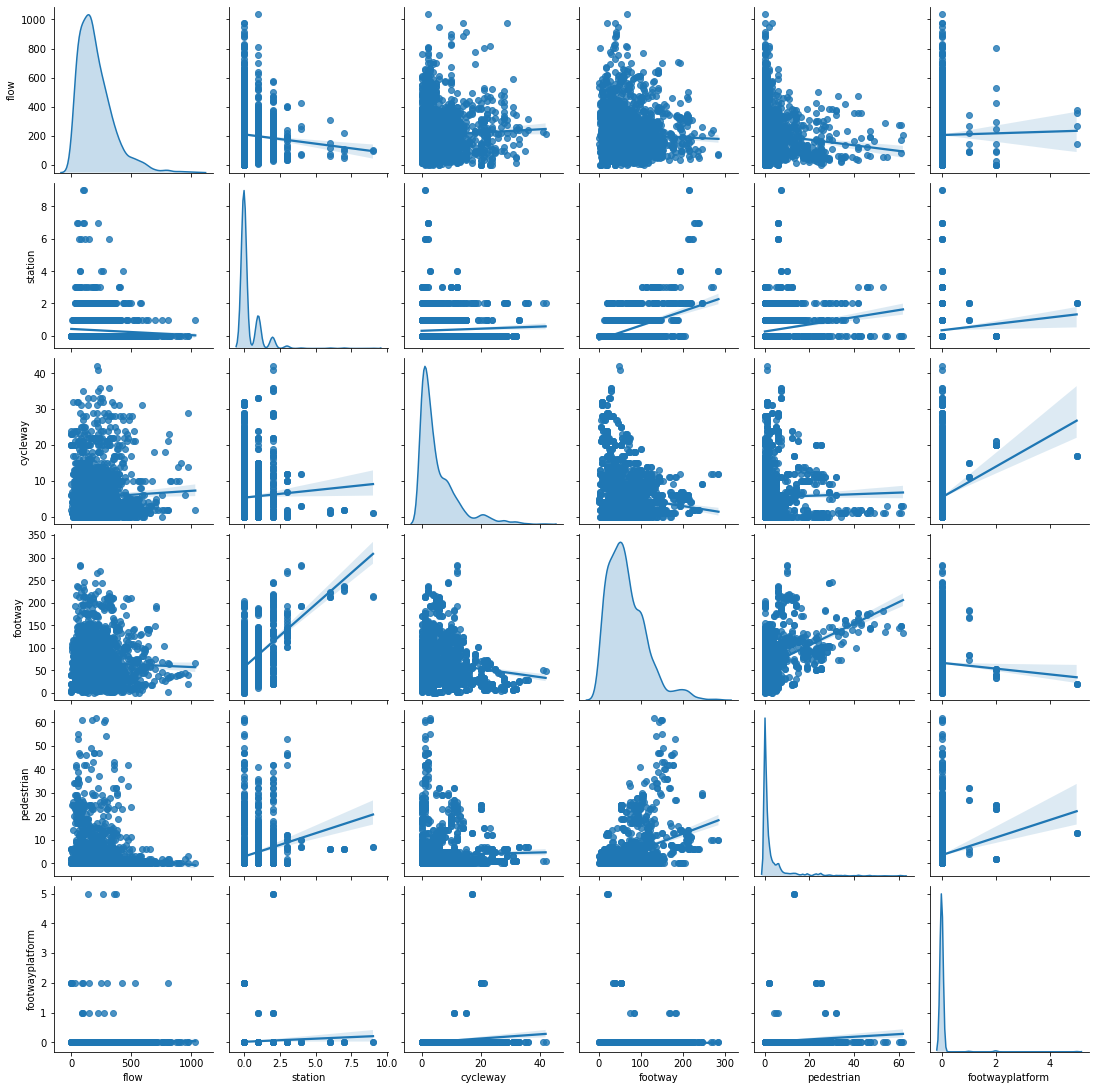

In [109]:
_ = sns.pairplot(all_cities[['flow', 'station', 'cycleway', 'footway', 'pedestrian', 'footwayplatform']], kind='reg', diag_kind='kde')

### Second iteration model

choices:
-create log of skewed variables
-remove footwayplatforms, since it's not very significant

In [46]:
all_cities['station_log'] = np.log(all_cities['station'].replace(0, np.nan))
all_cities['cycleway_log'] = np.log(all_cities['cycleway'].replace(0, np.nan))
all_cities['footway_log'] = np.log(all_cities['footway'].replace(0, np.nan))
all_cities['pedestrian_log'] = np.log(all_cities['pedestrian'].replace(0, np.nan))
all_cities['flow_log'] = np.log(all_cities['flow'].replace(0, np.nan))

# create second degree polynomial
#polynomial_features= PolynomialFeatures(degree=2)
#poly_constructionyear = polynomial_features.fit_transform(all_cities[['w_flow']])
#all_cities['w_flow_2'] = pd.DataFrame(poly_constructionyear)[2].values

all_cities = all_cities.fillna(0)

In [72]:
#all_cities.head()

In [86]:
regression_model2, y_train2, x_train2, y_test2, x_test2, predy_test2\
= regression(['flow'], ['station', 'cycleway_log', 'footway', 'pedestrian_log', 'City'], all_cities)

Shape of the training set is (1863, 15) and of the testing set is (466, 15).


In [87]:
print(regression_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     18.95
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           1.38e-27
Time:                        21:51:02   Log-Likelihood:                -11889.
No. Observations:                1863   AIC:                         2.380e+04
Df Residuals:                    1854   BIC:                         2.385e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            178.4445      6.103     29.

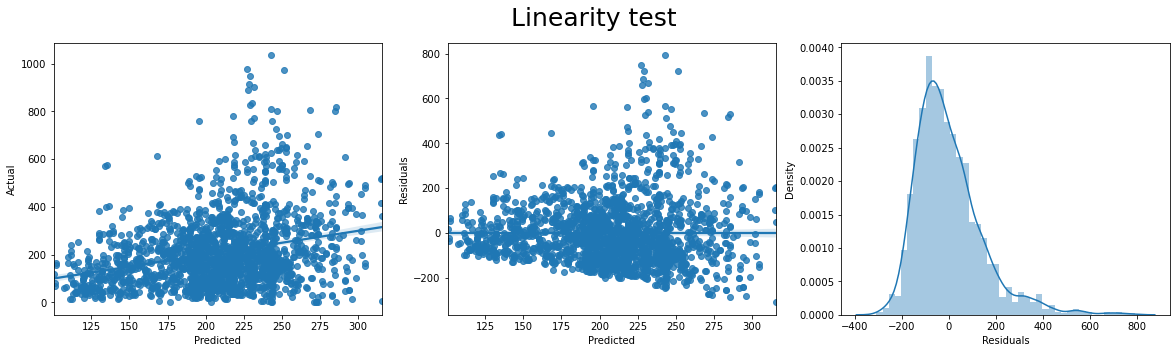

In [114]:
# residual analysis to determine whether assumption of linearity was correct
residuals2 = regression_model2.resid
predy_train2 = regression_model2.fittedvalues
#y_train2 = y_train2.reshape(y_train2.shape[0], )

linearity_check(x_train2, y_train2, residuals2, predy_train2)

In [113]:
R2score_model2, MAE_model2, rmse_model2 = get_teststats(y_test2, predy_test2)
print(f'R2-score 2: {R2score_model2}')
print(f'MAE 2:{MAE_model2}')
print(f'rmse 2: {rmse_model2}')


R2-score 2: 0.06901123606772619
MAE 2:107.21033990945352
rmse 2: 135.2342152961426


### Third iteration model